## Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
    <h1><center><strong>⁉️ Problem Introduction</strong></center></h1>
    <p>The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
        
While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
    </p>
    <hr>
    <p>
We have been asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)
    </p>
</div>

<div class="alert alert-warning">  
<h3><strong>Collect & Load Data</strong></h3>
</div>

In [2]:
# import gender_submission, train_data and test datasets using pandas 'read_csv' function
gender_submission = pd.read_csv('./datasets/gender_submission.csv')
train_data = pd.read_csv('./datasets/train.csv')
test_data = pd.read_csv('./datasets/test.csv')

Peek into imported datasets

In [3]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Definition of dataset:

In [4]:
data_definition = {'Variable':['survival', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
                   'Definition':['survival', 'Ticket class', 'Sex', 'Age in years', '# of siblings / spouses aboard the Titanic', \
                                 '# of parents / children aboard the Titanic', 'Ticket number', 'Passenger fare', 'Cabin number', 'Port of Embarkation'],
                   'Key':['0 = No, 1 = Yes', '1 = 1st, 2 = 2nd, 3 = 3rd', 'Male or Female', \
                          'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'C = Cherbourg, Q = Queenstown, S = Southampton']}

pd.DataFrame.from_dict(data_definition)

,Variable,Definition,Key
0,survival,survival,"0 = No, 1 = Yes"
1,Pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,Sex,Sex,Male or Female
3,Age,Age in years,NaN
4,SibSp,# of siblings / spouses aboard the Titanic,NaN
5,Parch,# of parents / children aboard the Titanic,NaN
6,Ticket,Ticket number,NaN
7,Fare,Passenger fare,NaN
8,Cabin,Cabin number,NaN
9,Embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


In [5]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


- `gender_submission` dataset only has 2 columns `PassengerId` and `Survived`. PassengerId kind of act as `key` which is connecting all three datasets.
- `train_data` dataset has 12 columnns which contains details about passengers with observed value of 'Survived' label.
- `test` dataset all 11 columns as in `train_data` dataset except `survived` column, which also makes sense as we are required to predict `survived` label for given observations in the test dataset.

<div class="alert alert-warning">  
<h3><strong>Exploratory Data Analysis</strong></h3>
</div>

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Before starting out data exploration and analysis part, first we can define important configurations for Pandas, Seaborn, or Matplotlib we will be using.

#### Matplotlib Parameters

In [6]:
# Consistent plots
from pylab import rcParams

rcParams['figure.figsize'] = 20,5
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.labelsize'] = 10

#### Color palette

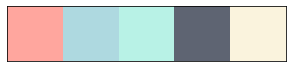

In [7]:
custom_colors = ["#ffa69e","#aed9e0","#b8f2e6","#5e6472","#faf3dd"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1)
plt.tick_params(axis='both', labelsize=0, length = 0)

#### Font size and font family

In [8]:
sns.set_theme(style='whitegrid', font='serif')

In [9]:
fig_title_prop = {'size': 18, 'color': '#4a4a4a', 'fontweight':'bold'}

In [10]:
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 2.5})

Before delving into analysis let's make sure that our data is in tidy format. 

Conditions to check if **data is tidy**:
- Is every column a variable? ✅
- Is every row an observation? ✅
- Is every table a single observational unit? ✅

Now we can start exploring our dataset.

In [11]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


From the given `Problem Statement` and `train_data` dataset, we can identify our `Predictor` and `Target` variables:
- Predictor Variables : Pclass, Gender, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
- Target Variable : Survived

Lets expolore `train_data` dataset:

#### Size of the dataset

In [12]:
train_data.shape

(891, 12)

we have 12 columns (11 features + 1 target) and 890 observations.

In [13]:
datadict = pd.DataFrame()
datadict['dtype'] = train_data.dtypes
datadict['count'] = train_data.count()
datadict['missing_val'] = train_data.isnull().sum()
datadict['missing_per'] = round(datadict['missing_val'] / datadict['count'], 2)
datadict['nunique'] = train_data.nunique()

In [14]:
datadict.sort_values(by=['dtype', 'missing_per'], ascending=False)

,dtype,count,missing_val,missing_per,nunique
Cabin,object,204,687,3.37,147
Name,object,891,0,0.00,891
Sex,object,891,0,0.00,2
Ticket,object,891,0,0.00,681
Embarked,object,889,2,0.00,3
Age,float64,714,177,0.25,88
Fare,float64,891,0,0.00,248
PassengerId,int64,891,0,0.00,891
Survived,int64,891,0,0.00,2
Pclass,int64,891,0,0.00,3


- Most of the data is numerical, 7 columns are numerical type and 5 are object / str type. 
- Some data is missing for columns `Age` and `Cabin`

#### Descriptive Statitics Summary

In [15]:
# get discripte statistcs on "object" datatypes
train_data.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Elsbury, Mr. William James",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [16]:
# get discriptive statistcs on "number" datatypes
train_data.describe(include=['number'])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- `Cabin` has missing data for around 77% of the rows, this could cause bais in the model so we will drop this column later.
- `Age` column has 20% missing data, we will replace missing values with `mean` or 'median` depending upon the distribution of data
- `Embarked` has missing data for 2 rows, we will drop these 2 rows

#### Univariate Analysis

Univariate analysis is the technique of comparing and analyzing the dependency of a single predictor and a response variable. The prefix "uni" means one, emphasizing the fact that the analysis only accounts for one variable's effect on a dependent variable. Univariate Analysis is thought to be one of the simplest forms of data analysis as it doesn't deal with causes or relationships, like a regression would. Primarily, Univariate Analysis simply takes data and provides a summary and associated patterns. 

In [17]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

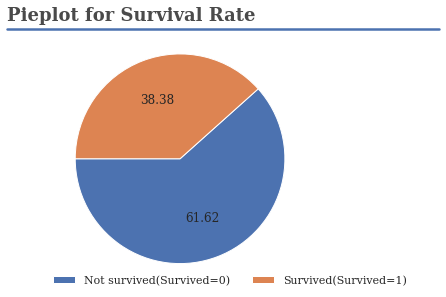

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

survive_per = train_data['Survived'].value_counts(normalize=True)

survive_per.plot(kind='pie', 
                 autopct='%.2f',
                 labels=None,
                 startangle = 180)

ax.set(ylabel='')

# add horizontal line
line = lines.Line2D([0, 1], [0.95, 0.95], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text
fig.text(0, 0.98, 'Pieplot for Survival Rate', fontdict=fig_title_prop)

labels=['Not survived(Survived=0)', 'Survived(Survived=1)']
plt.legend(labels = labels, loc=(0,0), edgecolor='None', ncol=2, bbox_transform=True)
plt.tight_layout()
plt.show()

Out of 891 passengers, only 38% survived, while majority 61% the passenger did not survive the disaster.

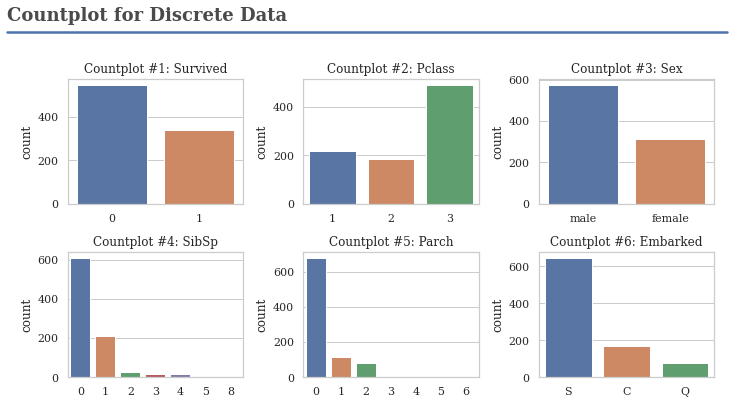

In [19]:
col_names = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
sub_count = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
fig.subplots_adjust(hspace=0.5)
# fig.suptitle('Countplot for Discrete Data', fontsize=15, fontweight=200)

for ax, feature in zip(axes.flatten(), train_data[col_names].columns):
    ax.set(title='Countplot #{}: {}'.format(sub_count, feature))
    ax.xaxis.label.set_visible(False)
    sns.countplot(train_data[feature],ax=ax)
    sub_count += 1

# add horizontal line
line = lines.Line2D([0, 1], [1.05, 1.05], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

fig.text(0, 1.08, 'Countplot for Discrete Data', fontdict=fig_title_prop)

plt.tight_layout()
plt.show()

💡 Tip: In case we want to create multiple `displot` we won't be able to do so with same for loop method as above, why?
- [Difference between displot vs histplot](https://stackoverflow.com/a/63895570/8390360)
- [How to create multiple displot in same figure](https://stackoverflow.com/a/63974061/8390360)

In [20]:
def triple_plot(data, title, c):
    fig, ax = plt.subplots(3,1,figsize=(12,6),sharex=True)
        
    # add distribution plot
    sns.distplot(data, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    
    # add box plot
    sns.boxplot(data, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    
    # add voilin plot
    sns.violinplot(data, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    
    # add figure title line
    line = lines.Line2D([0, 1], [1, 1], transform=fig.transFigure, zorder=1000, figure=fig)
    fig.lines.extend([line])
    
    # add title
    fig.text(x=0, y=1.03, s=title, fontdict=fig_title_prop)
     
    plt.tight_layout(pad=3.0)
    plt.show()

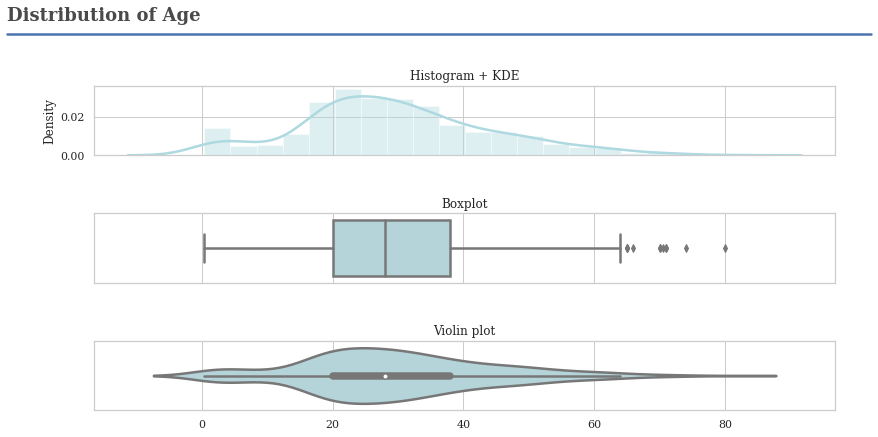

In [21]:
triple_plot(train_data['Age'], 'Distribution of Age', custom_colors[1])

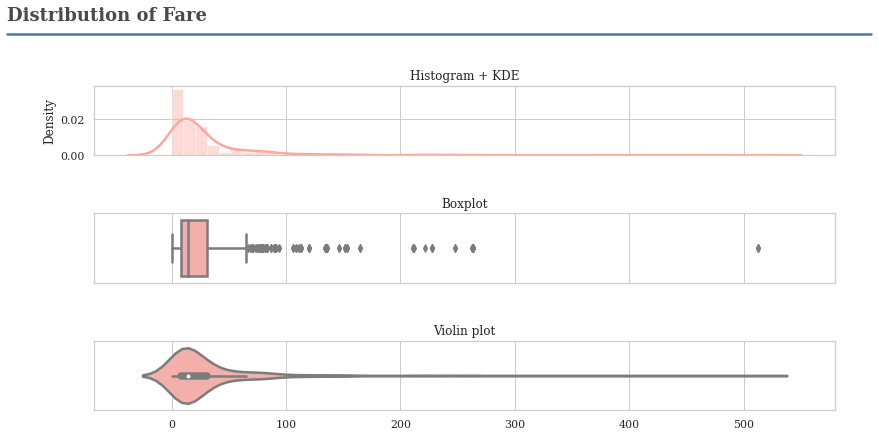

In [22]:
triple_plot(train_data['Fare'], 'Distribution of Fare', custom_colors[0])

Form these 2 plots we can gather that :
- For `Age` feature data is fairly normally distributed while `Fare` has high skewness which could be due to outlers. Next we will take a look at skewness and kurtosis for both `Age` and `Fare'
- From boxplot it is clear `Fare` feature has some high value outliers, we will check what are these outliers and what should we do with them.
- Also it is clear that most of `Fare` data is concentrated towards less values which indicates and also confirms that majority of people onboard purchased cheap tickets and thus there were more passengers with 3rd Class tickets, we can confirm this by checking correlation between `Fare` and `Pclass` features.

Let's check the distribution of both `Age` and `Fare` greater than 100.

💡 Tip: `value_counts()` is a Series method as doesn't apply on DataFrame. If we have to apply it on DataFrame then we have to first flatten() the DataFrame and then use `pd.value_counts(flattened DataFrae)` method. 

In [23]:
pd.value_counts(train_data[train_data['Age'] > 100]['Age'].values.flatten()).sum()

0

In [24]:
pd.value_counts(train_data[train_data['Fare'] > 100]['Fare'].values.flatten()).sum()

53

- Column `Age` doesn't have any value greater than 100 which also make sense because usually humans live less than 100 years.
- Column 'Fare` has 6% values which are greater than 100

So we will add filter to our `displot` data for `Age` and `Fare` and will only consider values < 101

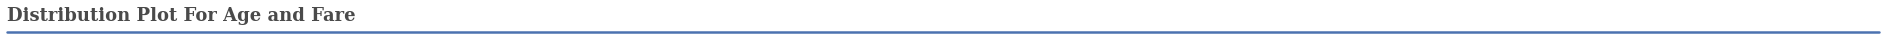

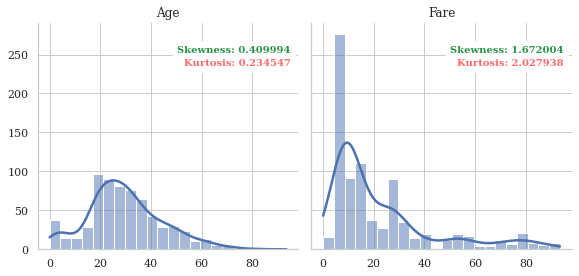

In [25]:
# select columns for which plot has to be created
train_data_age_fare_dis = train_data[train_data['Fare'] < 101][['Age', 'Fare']]

# now stack the data into a long (tidy) format
train_data_age_fare_dis = train_data_age_fare_dis.stack().reset_index(level=1).rename(columns={'level_1':'Column', 0:'Data'})

# add function for skewnewss and kurtosis annotation for each plot in facet grid
def annotate_skew_kurt(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(x=0.97, y=0.90, transform=ax.transAxes, s="Skewness: %f" % data.skew(),
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='#2b9348')
    ax.text(x=0.97, y=0.84, transform=ax.transAxes, s="Kurtosis: %f" % data.kurt(),
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='#ff6b6b')

# plot a displot
fig = plt.figure()
g = sns.displot(data=train_data_age_fare_dis, x='Data', col='Column', col_wrap=3, kde=True, height=4)
g.map_dataframe(annotate_skew_kurt)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

# add horizontal line
line = lines.Line2D([0, 1.3], [1.05, 1.05], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text as title
fig.text(0, 1.08, 'Distribution Plot For Age and Fare', fontdict=fig_title_prop)

plt.tight_layout()
plt.show()

Based on skewness and kurtosis values for `Age` column we can say that data is faily normally distributed while for `Fare` column we can say data is highly positvely skwed and also has moderate presensce of outliers as kurtosis is close.

We will check the characterstics of outlier's values in `Fare` feature based on which we will decide action in feature engineering section.

In [26]:
# move to feature enginnering
train_data.sort_values(by='Fare', ascending=False).head(5)

'''
Note: Move to feature engineering:
The outliers are actually not because of any error or sampling process, these are price of tickets which means they may have 
relation with other data in the dataset so we will keep these outliers.
'''

'\nNote: Move to feature engineering:\nThe outliers are actually not because of any error or sampling process, these are price of tickets which means they may have \nrelation with other data in the dataset so we will keep these outliers.\n'

### Multivariate Analysis

Multivariate data analysis is a set of statistical models that examine patterns in multidimensional data by considering, at once, several data variables. It is an expansion of bivariate data analysis, which considers only two variables in its models.

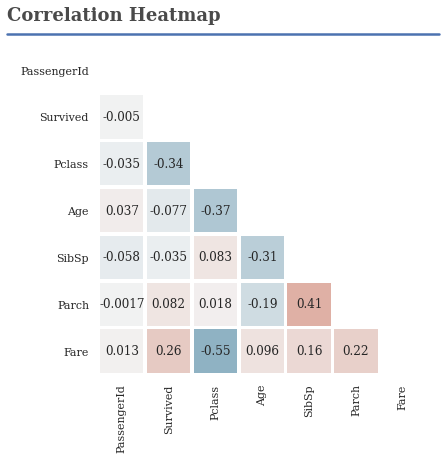

In [27]:
# create correlation matrix 
corr = train_data.corr()

# create figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# define mask to hide the upper triangle of the heatmap 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# define cmap for color mapping
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# rotate x axis ticks to 90 deg and y axis to 0 degree, set font size to 11 px
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)
ax.set_yticklabels(ax.get_xticklabels(), rotation = 0, fontsize=11)

# create heatmap plot
g = sns.heatmap(corr, 
                mask=mask,
                vmin=-1, vmax=1,
                linewidth=2.5,
                annot=True,
                cmap=cmap,
                cbar=False,
                ax=ax)

# add horizontal line
line = lines.Line2D([0, 1], [1, 1], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text as title
fig.text(0, 1.03, 'Correlation Heatmap', fontdict=fig_title_prop)

plt.tight_layout()
plt.show()

From Correlation heatmap it is evident that: 
- `Fare` and `Survived` are positively correlated.
- There is positive correlation between `Parch` and `SibSp`
- There is negative correlation between `Fare` and `Pclass`, this again confirms that most of people had bought low fare tickets and thus more passengers had 3rd class tickets.
- There is also negative correlation between `Pclass` and `Survive`, from this we can infer that lower that class (1 > 2 > 3) low were the chances of survival but we need to validate this.

What does positive and negative correlation means?
- **Positive Correlation:** This occurs when the value of one variable increases then the value of the other variable(s) also increases.
- **Negative Correlation:** This occurs when the value of one variable increases and the value of other variable(s) decreases.

Let's look deeper into survival rate and its relationship with other feature.
1. Find survival rate based on `sex`
2. Find survival rate based on `age band` for this we will have to populate our dataframe with age ranges (bin size = 10) based on the age of the passengers.
3. Check survival rate based on `class`.

Survival rate based on Sex

Groupby `Sex` feature and find percentage of `Survived`. Since Survived data is in 0 or 1 therefore aggregation as `mean()` is sufficient to find percentage.

In [28]:
survival_rate = pd.DataFrame(train_data.groupby('Sex').mean()['Survived'])
male_rate = survival_rate.loc['male']
female_rate = survival_rate.loc['female']

In [29]:
"""
np.random.uniform() generates random samples from uniform distribution and returns the random samples as numpy array.

Parameters for this method are low=0.0, high=1.0, size=None
"""

male_pos = np.random.uniform(0, male_rate, len(train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 1)]))
male_neg = np.random.uniform(male_rate, 1, len(train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 0)]))
female_pos = np.random.uniform(0, female_rate, len(train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 1)]))
female_neg = np.random.uniform(female_rate, 1, len(train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 0)]))

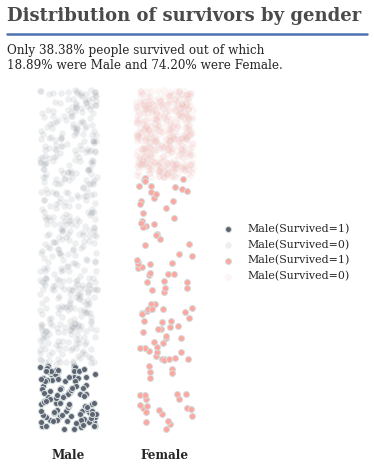

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))

np.random.seed(42)

# Male Stripplot
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_pos)), male_pos, color='#5e6472', edgecolor='#d4dddd', label='Male(Survived=1)')
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_neg)), male_neg, color='#5e6472', edgecolor='#d4dddd', alpha=0.1, label='Male(Survived=0)')

# Female Stripplot
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_pos)), female_pos, color='#ffa69e', edgecolor='#d4dddd', label='Male(Survived=1)')
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_neg)), female_neg, color='#ffa69e', edgecolor='#d4dddd', alpha=0.1, label='Male(Survived=0)')

# Set Figure & Axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.03, 1.1)

# Ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'], fontweight='bold', fontsize=12)
ax.set_yticks([], minor=False)
ax.set_ylabel('')

# remove figure borders
for s in ["top", "right","left", 'bottom']:
    ax.spines[s].set_visible(False)

# add horizontal line
line = lines.Line2D([0, 1], [1.02, 1.02], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text as title
fig.text(0, 1.05, 'Distribution of survivors by gender', fontdict=fig_title_prop)
fig.text(0, 0.94, 
         'Only {:.2f}% people survived out of which\n{:.2f}% were Male and {:.2f}% were Female.'.format(
             survive_per[1]*100, 
             male_rate[0]*100, 
             female_rate[0]*100),
         ha='left'
        )

ax.legend(loc=(1, 0.4), edgecolor='None')
plt.grid()
plt.tight_layout()
plt.show()

Survival rate based on age of the passengers

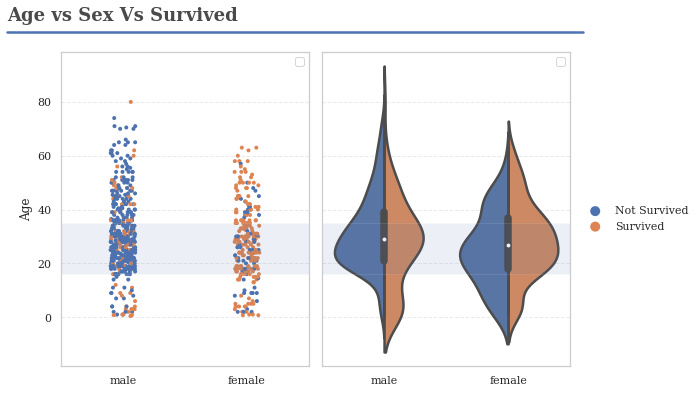

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
sns.stripplot(x="Sex", y="Age", hue='Survived', data=train_data, size=4, ax=ax[0])
ax[0].set(xlabel='')
ax[0].legend(labels='')


sns.violinplot(x='Sex', y='Age', data=train_data, hue='Survived', split=True, ax=ax[1])
ax[1].set(xlabel='')
ax[1].set(ylabel='')
ax[1].legend(labels='')

# add horizontal line
line = lines.Line2D([0, 1], [1.02, 1.02], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text as title
fig.text(0, 1.05, 'Age vs Sex Vs Survived', fontdict=fig_title_prop)  

fig.legend(labels=['Not Survived', 'Survived'], loc = 'center right', edgecolor='None', ncol=1, markerscale=2.5, bbox_to_anchor=(1.2, 0.5))

# add grid and horizontal span for both axes
for i in range(len(ax)):
    ax[i].grid(axis='y', linestyle='--', alpha=0.4)
    ax[i].axhspan(xmin=0, xmax=1, ymin=16, ymax=35 ,facecolor="b",alpha=0.1, zorder=1000)
    
plt.tight_layout()
plt.show()

- For male between the age range of 20-30 years, chances of survial are low
- For female data is faily distributed throughout the y axis

First we will create a function to convert passenger age into a range.

In [32]:
# define funcction for converting age into age band
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

Now we will populate out train_dataing dataset with age ranges based on passenger age. 

In [33]:
# add column in train_data dataframe for age_band
train_data['age_band'] = train_data['Age'].apply(age_band)

Calculate surviaval rate for each age groups. Since our `age_band` feature  and aggregated data has some NaN values, thus we will use fillna() and replace NaN with zeros.

In [34]:
titanic_age = train_data[['age_band', 'Survived']].groupby('age_band')['Survived'].value_counts().sort_index().unstack()
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100
titanic_age.fillna(0, inplace=True)

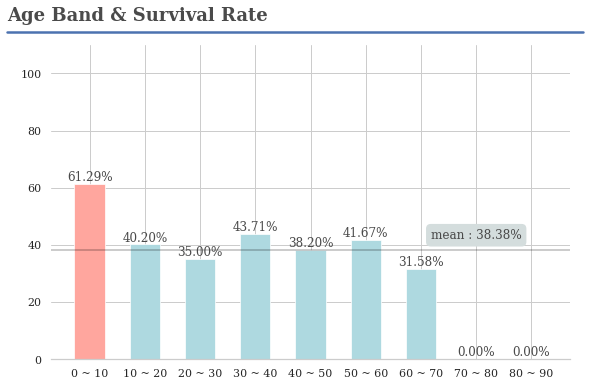

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig.subplots_adjust(top=0.8)

color_map = ['#aed9e0' for _ in range(9)]
color_map[0] = color_map[8] = '#ffa69e' # color highlight

ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
#        edgecolor='black', 
       linewidth=0.7)
ax.set_ylim(0, 110)

for s in ["top", "right","left"]:
    ax.spines[s].set_visible(False)

# Annotation Part
for i in titanic_age['Survival rate'].index:
    ax.annotate(f"{titanic_age['Survival rate'][i]:.02f}%", 
                   xy=(i, titanic_age['Survival rate'][i] + 2.3),
                   va = 'center', ha='center',fontweight='light', 
                   color='#4a4a4a')

# mean line + annotation
mean = train_data['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='-')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('70 ~ 80', mean + 5),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#d4dddd', linewidth=0))

# add horizontal line
line = lines.Line2D([0, 1], [1, 1], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

# add figure text as title
fig.text(0, 1.03, 'Age Band & Survival Rate', fontdict=fig_title_prop)

grid_y_ticks = np.arange(0, 101, 20)
ax.set_yticks(grid_y_ticks)
# ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

From the analysis we can infer that:
1. There is 100% survival rate for age band 80-90, but there was only 1 passenger in this range. We will try to eliminate this row as it can affect our model. Also does ticket class has any impact on his survival?
2. There is no one in age range 70-80 who survived. Find out were they all in 3rd Class?
3. Passengers with age range between 0-10 years has best survival rate, it also makes sense as protection of kids and women must have been priority.
4. Old people had less chance of survival while for young passenger age range 20-30 is exception as their survival rate is lower than mean. Why?

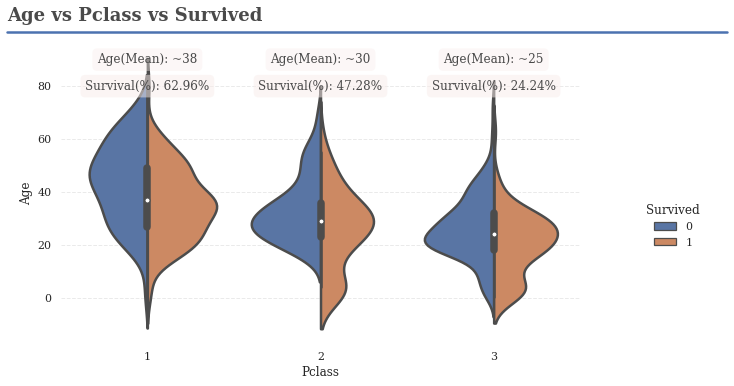

In [36]:
# mean age for each class
pclass_age_mean = train_data[['Age', 'Pclass']].groupby('Pclass').mean()
pclsas_survival_rate = train_data[['Survived', 'Pclass']].groupby(['Pclass']).mean()

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.violinplot(x="Pclass", y="Age", hue="Survived", split=True, data=train_data)
    
for i in ['top', 'right', 'left', 'bottom']:
    ax.spines[i].set_visible(False)

# mean line + annotation
for i in range(len(pclass_age_mean)):
    ax.annotate("Age(Mean): ~{:.0f}".format(pclass_age_mean['Age'].iloc[i]), 
            xy=(i, 90),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#f8edeb', linewidth=0, alpha=0.4))
    ax.annotate("Survival(%): {:.2f}%".format(pclsas_survival_rate['Survived'].iloc[i]*100), 
            xy=(i, 80),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#f8edeb', linewidth=0, alpha=0.5))

line = lines.Line2D([0,1], [1,1], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

fig.text(0, 1.03, 'Age vs Pclass vs Survived', fontdict=fig_title_prop)

ax.legend(title='Survived', edgecolor='None', numpoints=1, markerscale=5, bbox_to_anchor=(1.25, 0.5)) 
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

From the above chart it is clear that:
1. Class 3 has most of Class 3 has the lowest mean age (~ 25 years) and lowest survival rate (~ 24%) of all three class
2. Class 1 has highest mean age (~ 38 years) and survival rate (~ 63%) of all three classes 

Survival rate vs Fare

In [37]:
pclass_ulist = list(range(train_data['Pclass'].nunique()))
sex_ulist = list(train_data['Sex'].unique())

class_gen = {'Pclass':[], 'Sex':[], 'Count':[], 'Count_per': [], 'Mean_Fare':[]}

for i in pclass_ulist:
    for j in sex_ulist:
        count = train_data[(train_data['Pclass'] == i+1) & (train_data['Sex'] == j)]['Name'].count()
        mean_fare = train_data[(train_data['Pclass'] == i+1) & (train_data['Sex'] == j)]['Fare'].mean()
        class_gen['Pclass'].append(i+1)
        class_gen['Sex'].append(j)
        class_gen['Count'].append(count)
        class_gen['Count_per'].append(round(count / len(train_data) * 100, 2))
        class_gen['Mean_Fare'].append(round(mean_fare, 2))
        
pd.DataFrame.from_dict(class_gen)

,Pclass,Sex,Count,Count_per,Mean_Fare
0,1,male,122,13.69,67.23
1,1,female,94,10.55,106.13
2,2,male,108,12.12,19.74
3,2,female,76,8.53,21.97
4,3,male,347,38.95,12.66
5,3,female,144,16.16,16.12


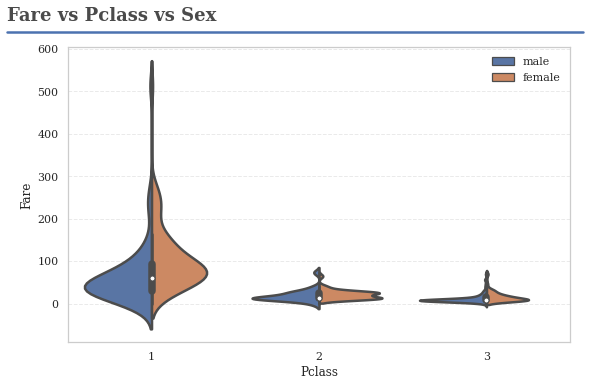

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.violinplot(y='Fare', x='Pclass', hue='Sex', data=train_data, split=True)

line = lines.Line2D([0,1], [1,1], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

fig.text(0, 1.03, 'Fare vs Pclass vs Sex', fontdict=fig_title_prop)

ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(edgecolor='None')
plt.tight_layout()

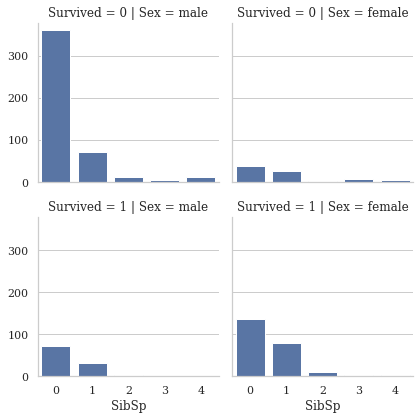

In [78]:
g = sns.FacetGrid(train_data, col="Sex", row="Survived")
g.map(sns.countplot, "SibSp")

line = lines.Line2D([0,1], [1,1], transform=fig.transFigure, zorder=1000, figure=fig)
fig.lines.extend([line])

fig.text(0, 1.03, 'SibSp vs Sex vs Survived', fontdict=fig_title_prop)

plt.tight_layout()

Conclusions so far:
- Only 38% passengers survived, Survival rate for female is way higher than male << Survival Rate {Male = 19%, Female = 72%} >>
- Fare of 3rd Class was very cheap << Mean fares {1st Class = 13,  2nd Class = 20,  3rd Class = 84} >>
- Majority of passengers were travelling through 3rd Class << Population Percentage {1st Class = 24%, 2nd Class = 20%, 3rd Class = 55%} >>
- Majority of passengers travelling thorugh 3rd class were male (~38%)
- Majority of passengers travelling were young (between 20 to 40 years = ~33%), 14% were travelling through 3rd Class

<div class="alert alert-warning">  
<h3><strong>Feature Engineering</strong></h3>
</div>

>The features you use influence more than everything else the result. No algorithm alone, to my knowledge, can supplement the information gain given by correct feature engineering.
— Luca Massaron

Feature engineering efforts mainly have two goals:
1. Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
2. Improving the performance of machine learning models.

#### Cleaning The Data

We will create a list and pass both train and test datasets, so that we can use for loop to apply feature engineering operations on both datasets at once.

In [86]:
clean_data = [train_data, test_data]

Let's graphically visualize the missing values in the train dataset

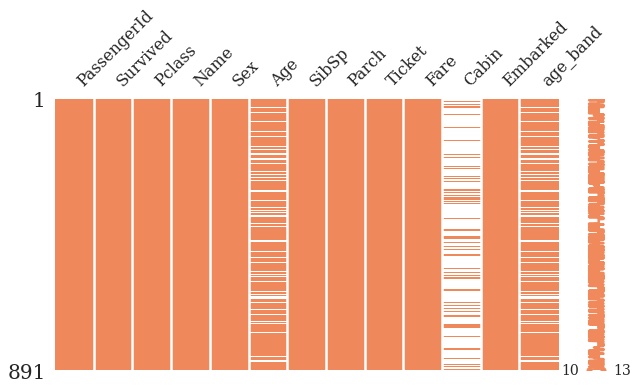

In [79]:
msno.matrix(train_data, color=(0.94, 0.54, 0.36), figsize=(10,5))
plt.show()

In [92]:
###COMPLETING: complete missing values in train and test dataset
for dataset in clean_data:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
### DELETING: delete unrequired columns in test dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
test_data.drop(drop_column, axis=1, inplace = True)

In [118]:
print(
    'Train dataset has {} missing values\nTest dataset has {} missing values'.format(
        np.sum(train_data.isnull().sum()), 
        np.sum(test_data.isnull().sum())) 
)

Train dataset has 864 missing values
Test dataset has 0 missing values


In [129]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in clean_data:    
    #Discrete variables
    dataset['familySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['isAlone'] = 1 #initialize to yes/1 is alone
    dataset['isAlone'].loc[dataset['familySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    # we will use regex to extract title
    dataset['nameTitle'] = dataset['Name'].str.extract('([a-zA-Z]+\.)', expand=True)[0]
    
    # create fare and bin using qcut
    dataset['fareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['ageBin'] = pd.cut(dataset['Age'].astype(int), 5)  

In [133]:
# convert title with count less than 10 to 'Misc.'  
stat_min = 10
title_names = (train_data['nameTitle'].value_counts() < stat_min) #this will create a true false series with title name as index
train_data['nameTitle'] = train_data['nameTitle'].apply(lambda x: 'Misc.' if title_names.loc[x] == True else x)
print(train_data['nameTitle'].value_counts())

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Misc        27
Name: nameTitle, dtype: int64


In [138]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [140]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

label = LabelEncoder()
for dataset in clean_data:    
    dataset['sexCode'] = label.fit_transform(dataset['Sex'])
    dataset['embarkedCode'] = label.fit_transform(dataset['Embarked'])
    dataset['nameTitleCode'] = label.fit_transform(dataset['nameTitle'])
    dataset['ageBinCode'] = label.fit_transform(dataset['ageBin'])
    dataset['fareBinCode'] = label.fit_transform(dataset['fareBin'])

In [141]:
# define y variable aka target
Target = ['Survived']

In [174]:
# define x variables for original features aka feature selection for algo training
train_x = ['Sex','Pclass', 'Embarked', 'nameTitle','SibSp', 'Parch', 'Age', 'Fare', 'familySize', 'isAlone']
train_x_calc = ['sexCode','Pclass', 'embarkedCode', 'nameTitleCode','SibSp', 'Parch', 'Age', 'Fare']
train_xy = Target + train_x

In [175]:
# define x variables for original with bin features to remove continuous variables
train_x_bin = ['Sex_Code','Pclass', 'embarkedCode', 'nameTitleCode', 'familySize', 'ageBinCode', 'fareBinCode']
train_xy_bin = Target + train_x_bin

In [180]:
# define x and y variables for dummy features original
train_dummy = pd.get_dummies(train_data[train_x])
train_x_dummy = train_dummy.columns.tolist()
train_xy_dummy = Target + train_x_dummy
train_dummy.head()

,Pclass,SibSp,Parch,Age,Fare,familySize,isAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,nameTitle_Master.,nameTitle_Misc,nameTitle_Miss.,nameTitle_Mr.,nameTitle_Mrs.
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [ ]:
# split train and test data with function defaults

# random_state -> seed or control random number generator
train_x, test_x, train_y, test_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)

<div class="alert alert-warning">  
<h3><strong>Model Selection</strong></h3>
</div>

<div class="alert alert-warning">  
<h3><strong>Model Training</strong></h3>
</div>

<div class="alert alert-warning">  
<h3><strong>Model Evaluation</strong></h3>
</div>

<div class="alert alert-warning">  
<h3><strong>Conclusion</strong></h3>
</div>

In [ ]:
train_data['PassengerId'].count

https://www.kaggle.com/ruchi798/break-the-ice

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy